Tudo da vida segue uma distribuição gaussiana.
-V.C.A Marcelo

### Libraries

In [1]:
import pandas as pd
import numpy as np
from custom_metrics import regression_metrics

### Functions

In [2]:
def order_by_x(x, y):
    # developed by segfault
    lst = list(zip(x_train, y_train))
    lst_ordered = sorted(lst)
    xt, yt = list(zip(*lst_ordered))
    xt = list(xt)
    yt = list(yt)
    
    return(xt, yt)

Reading dataframes

In [3]:
df_gold = pd.read_csv('../data/d_kilo_gold_price_in_currency.csv')
df_gold['date'] = pd.to_datetime(df_gold['date'], infer_datetime_format=True)

### Configuration

In [4]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

COLOR_DATA_TEST="blue"
COLOR_DATA_PRED="red"

<Figure size 1280x960 with 0 Axes>

In [5]:
from sklearn.model_selection import train_test_split

data_x = np.arange(0, len(df_gold['date'])).reshape(-1,1)
data_y = np.array(df_gold['China'])

x_train, x_test, y_train, y_test = train_test_split(data_x, 
                                                    data_y, 
                                                    test_size=0.50)
print("Train length:", len(x_train))
print("Test  length:", len(x_test))

Train length: 183
Test  length: 183


### Visualization


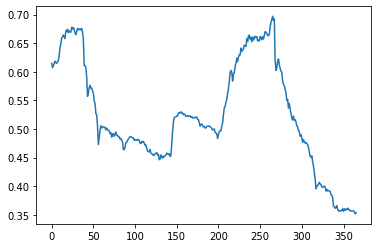

In [6]:
import matplotlib.pyplot as plt
plt.plot(data_x, data_y)

## Linear Regression

[source](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py)

Coeficiente:  -0.00038077480674252604


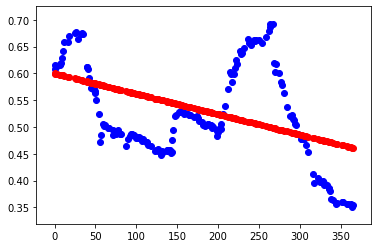

MSE:  0.006638423364084645
RMSE: 0.08147652032386168
MAE:  0.06857245039308155
MAPE: 0.15839486321366067
R2:   0.12009886533815828


0.12009886533815828

In [7]:
from sklearn import linear_model
import matplotlib.pyplot as plt

model = linear_model.LinearRegression()
model.fit(x_train, y_train.reshape(-1,1))

print("Coeficiente: ", model.coef_[0][0])

y_pred = model.predict(x_test)

plt.scatter(x_test, y_test, color=COLOR_DATA_TEST)
plt.scatter(x_test, y_pred, color=COLOR_DATA_PRED)
plt.show()

regression_metrics(y_test, y_pred, verbose=True)

## Polynomial Regression

[source](https://towardsdatascience.com/polynomial-regression-with-scikit-learn-what-you-should-know-bed9d3296f2)

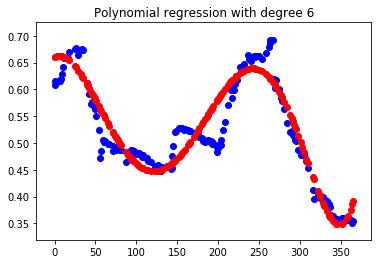

MSE:  0.001229242369189491
RMSE: 0.03506055289337992
MAE:  0.026998657078833463
MAPE: 0.05181015509801259
R2:   0.8370679759178956


0.8370679759178956

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

degree = 6
poly_reg = make_pipeline(PolynomialFeatures(degree),LinearRegression())
poly_reg.fit(x_train, y_train)
y_pred = poly_reg.predict(x_test)

plt.figure()
plt.scatter(x_test, y_test, color=COLOR_DATA_TEST)
plt.scatter(x_test, y_pred,color=COLOR_DATA_PRED)
plt.title("Polynomial regression with degree "+str(degree))
plt.show()

regression_metrics(y_test, y_pred, verbose=True)

## Support Vector Regression

[source](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

C = 1.0 epsilon = 0.1


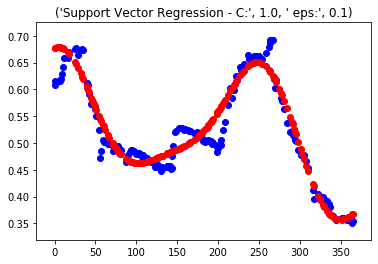

MSE:  0.0007847474117316042
RMSE: 0.028013343458637784
MAE:  0.021149149933954274
MAPE: 0.0401868791968642
R2:   0.8959843173393637


0.8959843173393637

In [12]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

parameters = { 'C'      : [2e0, 2e-1, 2e-2, 2e-3, 2e-4, 2e-5, 2e-6], 
               'epsilon': [1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6] }

# https://stackoverflow.com/a/43366811/2679529
clf = make_pipeline(StandardScaler(), 
                    GridSearchCV(SVR(),
                                 param_grid=parameters,
                                 cv=5,
                                 refit=True))
clf.fit(x_train, y_train)

# https://scikit-learn.org/stable/modules/compose.html#nested-parameters
melhor_c = clf.get_params()['gridsearchcv__estimator__C']
melhor_epsilon = clf.get_params()['gridsearchcv__estimator__epsilon']
print('C =', melhor_c, 'epsilon =', melhor_epsilon)

y_pred = clf.predict(x_test)

r2 = regression_metrics(y_test, y_pred)
        
plt.figure()
plt.scatter(x_test, y_test, color=COLOR_DATA_TEST)
plt.scatter(x_test, y_pred,color=COLOR_DATA_PRED)
plt.title(("Support Vector Regression - C:",melhor_c," eps:",melhor_epsilon))
plt.show()

regression_metrics(y_test, y_pred, verbose=True)

## Multi-layer Perceptron regressor

[source](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)

In [ ]:
from sklearn.neural_network import MLPRegressor


#activation_arr=['identity', 'logistic', 'tanh', 'relu']
activation_arr=['relu']
layer_size_arr=np.linspace(5, 1000, 200, dtype='int64')

melhor_activation=None
melhor_layer_size=None
melhor_r2=float("-inf")
y_pred = []

for a in activation_arr:
    for l in layer_size_arr:

            regr = make_pipeline(StandardScaler(), MLPRegressor(
                                random_state=42, 
                                hidden_layer_sizes=(l,l), 
                                activation=a))
            
            regr.fit(x_train, y_train)

            y_pred = regr.predict(x_test)
            #regr.score(x_test, y_test)

            r2 = regression_metrics(y_test, y_pred)

            if r2 > melhor_r2:
                melhor_r2 = r2
                melhor_activation = a
                melhor_layer_size = (l,l)
                print(melhor_r2, melhor_activation, melhor_layer_size)


regr = make_pipeline(StandardScaler(), MLPRegressor(
                                random_state=42, 
                                hidden_layer_sizes=melhor_layer_size, 
                                activation=melhor_activation))
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)
r2 = regression_metrics(y_test, y_pred)

plt.scatter(x_test, y_test, color=COLOR_DATA_TEST)
plt.scatter(x_test, y_pred, color=COLOR_DATA_PRED)
plt.show()

regression_metrics(y_test, y_pred, verbose=True)

## Prophet

In [ ]:
import pandas as pd
from fbprophet import Prophet

m = Prophet()

m.fit(pd.DataFrame(x_train,y_train))

In [ ]:
import pystan
model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
model = pystan.StanModel(model_code=model_code)  # this will take a minute
y = model.sampling(n_jobs=1).extract()['y']
y.mean()  # should be close to 0